In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install flaml
!pip install catboost
!pip install pycaret
!pip install librosa
!pip install numba==0.53  
!pip install scikit-learn==0.24

In [27]:
import numpy as np
import pandas as pd
import random as rn
import os

import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sys
import seaborn as sns
import random as rn
import os
import scipy.stats as stats

from scipy.io import wavfile
import librosa
import IPython.display as ipd
import librosa.display
from tqdm.auto import tqdm
# from pycaret.anomaly import *
from collections import Counter
# from flaml import AutoML

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 

In [4]:
%cd '/content/drive/MyDrive/Machine_fault/'

/content/drive/MyDrive/Machine_fault


In [5]:
# reproducibility

def all_seed(seed_num):
    np.random.seed(seed_num)
    rn.seed(seed_num)
    os.environ['PYTHONHASHSEED']=str(seed_num)
    # tf.random.set_seed(seed_num)

seed_num = 42
all_seed(seed_num)

In [6]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [7]:
train.head()

,SAMPLE_ID,SAMPLE_PATH,FAN_TYPE,LABEL
0,TRAIN_0000,./train/TRAIN_0000.wav,2,0
1,TRAIN_0001,./train/TRAIN_0001.wav,0,0
2,TRAIN_0002,./train/TRAIN_0002.wav,0,0
3,TRAIN_0003,./train/TRAIN_0003.wav,2,0
4,TRAIN_0004,./train/TRAIN_0004.wav,2,0


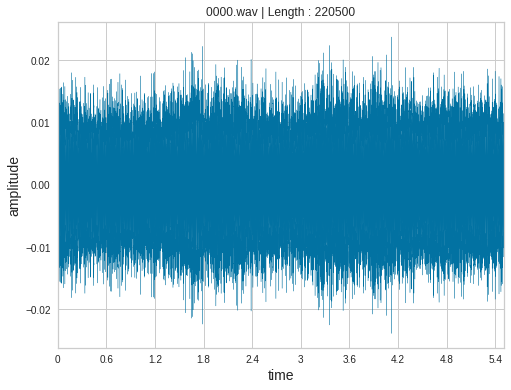

In [15]:
a_filename = 'dataset/train/TRAIN_0000.wav'
samples, sample_rate = librosa.load(a_filename)

plt.figure(figsize=(8,6))
librosa.display.waveplot(samples, sr=40000)
plt.xlabel('time', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.title('0000.wav | Length : ' + str(len(samples)))

plt.show()

In [16]:
print(sample_rate)
print(samples)

22050
[-3.2034223e-03 -2.2525194e-03  7.2167447e-04 ...  7.9414040e-09
  6.4239787e-09 -1.1652422e-08]


In [17]:
samples = np.array(samples, dtype='float64')

samples = librosa.resample(samples, sample_rate, 20000)
ipd.Audio(samples, rate=20000)

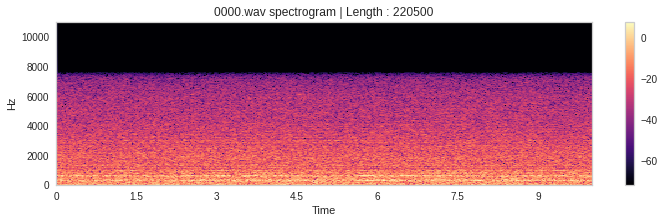

In [18]:
samples, sample_rate = librosa.load(a_filename)
X = librosa.stft(samples)  # data -> short term FT
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(12, 3))
plt.title('0000.wav spectrogram | Length : ' + str(len(samples)))
librosa.display.specshow(Xdb, sr = sample_rate, x_axis='time', y_axis='hz')   
plt.colorbar()
plt.show()

In [28]:
# noise 추가
def noise(sample):
    noise_amp = 0.01*np.random.uniform()*np.amax(sample)
    sample = sample + noise_amp*np.random.normal(size = sample.shape[0])
    return sample

# time stretching
def stretch(sample, rate = 0.8):
    stretch_sample = librosa.effects.time_stretch(sample, rate)
    return stretch_sample

# pitch 변환
def pitch(sample, sampling_rate, pitch_factor = 0.8):
    pitch_sample = librosa.effects.pitch_shift(sample, sampling_rate, pitch_factor)
    return pitch_sample

In [29]:
def extract_features(sample, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y = sample).T, axis=0)
    result=np.hstack((result, zcr)) 

    # Chroma_stft
    stft = np.abs(librosa.stft(sample))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S = stft, sr = sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y = sample, sr = sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y = sample, sr = sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y = sample).T, axis=0)
    result = np.hstack((result, rms)) 

    return result

In [30]:
def get_features(path):

    sample, sample_rate = librosa.load(path)
    
    # without augmentation
    res1 = extract_features(sample, sample_rate)
    result = np.array(res1)
    
    # sample with noise
    noise_sample = noise(sample)
    res2 = extract_features(noise_sample, sample_rate)
    result = np.vstack((result, res2)) 
    
    # sample with stretching and pitching
    str_sample = stretch(sample)
    sample_stretch_pitch = pitch(str_sample, sample_rate)
    res3 = extract_features(sample_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) 
    
    return result

In [47]:
file_name = train['SAMPLE_ID']
train_path = 'dataset/train/'

In [ ]:
labels = train['LABEL']
x, y = [], []
for f, label in zip(file_name, labels):
    feature = get_features(train_path + f + '.wav')
    for fe in feature:
        x.append(fe)
        y.append(label)
    print(f)

In [52]:
X = np.array(x)
Y = np.array(y)

print("Shape of X:", np.shape(X))
print("Shape of Y:", np.shape(Y))

Shape of X: (3837, 162)
Shape of Y: (3837,)


In [53]:
np.save('X.npy', X)
np.save('Y.npy', Y)

In [8]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [16]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [17]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")

In [ ]:
# autoencoder.fit(X, X, 
#                 batch_size = 32, epochs = 10, 
#                 shuffle = True, validation_split = 0.2);

In [18]:
X_scaled = preprocessing.MinMaxScaler().fit_transform(X)
autoencoder.fit(X_scaled, X_scaled, 
                batch_size = 32, epochs = 50, 
                shuffle = True, validation_split = 0.2);

Epoch 1/50
96/96 [==============================] - 2s 5ms/step - loss: 0.0260 - val_loss: 0.0147
Epoch 2/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 3/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 4/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 5/50
96/96 [==============================] - 1s 5ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 6/50
96/96 [==============================] - 1s 7ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 7/50
96/96 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 8/50
96/96 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 9/50
96/96 [==============================] - 0s 5ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 10/50
96/96 [==============================] - 1s 9ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 11/50
96/96 [

In [19]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

# **Test**

In [97]:
def get_features_test(path):

    sample, sample_rate = librosa.load(path)
    
    res = np.array([])
    # without augmentation
    res1 = extract_features(sample, sample_rate)
    result = np.array(res1)
    
    return result

In [98]:
test_file_name = test['SAMPLE_ID']
test_path = 'dataset/test/'

In [99]:
test_x = []
for f in test_file_name:
    feature = get_features_test(test_path + f + '.wav')
    test_x.append(feature)
    print(f)

TEST_0000
TEST_0001
TEST_0002
TEST_0003
TEST_0004
TEST_0005
TEST_0006
TEST_0007
TEST_0008
TEST_0009
TEST_0010
TEST_0011
TEST_0012
TEST_0013
TEST_0014
TEST_0015
TEST_0016
TEST_0017
TEST_0018
TEST_0019
TEST_0020
TEST_0021
TEST_0022
TEST_0023
TEST_0024
TEST_0025
TEST_0026
TEST_0027
TEST_0028
TEST_0029
TEST_0030
TEST_0031
TEST_0032
TEST_0033
TEST_0034
TEST_0035
TEST_0036
TEST_0037
TEST_0038
TEST_0039
TEST_0040
TEST_0041
TEST_0042
TEST_0043
TEST_0044
TEST_0045
TEST_0046
TEST_0047
TEST_0048
TEST_0049
TEST_0050
TEST_0051
TEST_0052
TEST_0053
TEST_0054
TEST_0055
TEST_0056
TEST_0057
TEST_0058
TEST_0059
TEST_0060
TEST_0061
TEST_0062
TEST_0063
TEST_0064
TEST_0065
TEST_0066
TEST_0067
TEST_0068
TEST_0069
TEST_0070
TEST_0071
TEST_0072
TEST_0073
TEST_0074
TEST_0075
TEST_0076
TEST_0077
TEST_0078
TEST_0079
TEST_0080
TEST_0081
TEST_0082
TEST_0083
TEST_0084
TEST_0085
TEST_0086
TEST_0087
TEST_0088
TEST_0089
TEST_0090
TEST_0091
TEST_0092
TEST_0093
TEST_0094
TEST_0095
TEST_0096
TEST_0097
TEST_0098
TEST_0099


In [116]:
X_test = np.array(test_x)

print("Shape of X test:", np.shape(X_test))

Shape of X test: (1514, 162)


In [117]:
np.save('X_test.npy', X_test)

In [118]:
X_test = np.load('X_test.npy')

In [119]:
X_test_scaled = preprocessing.MinMaxScaler().fit_transform(X_test)

In [120]:
X_test_scaled.shape

(1514, 162)

In [121]:
test_pred = autoencoder.predict(X_test_scaled)

48/48 [==============================] - 0s 2ms/step


In [122]:
np.save('test_pred.npy', test_pred)
test_pred = np.load('test_pred.npy')

In [123]:
mse = np.mean(np.power(X_test_scaled - test_pred, 2), axis=1)
print(mse.shape)

(1514,)


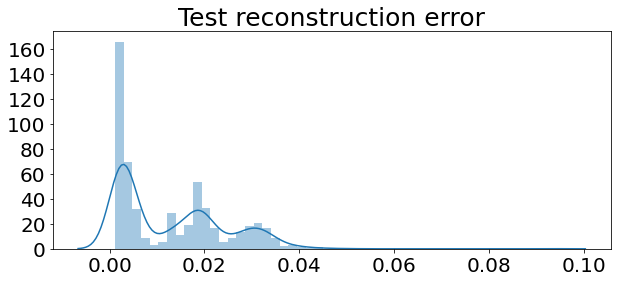

In [124]:
fig = plt.figure(figsize = (10,4))

sns.distplot(mse, bins = 50);
plt.ylabel('')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Test reconstruction error', fontsize = 25)
plt.show()

In [142]:
THRESHOLD = 2

def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

In [143]:
# outlier 1
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

Detected 593 outliers in a total of 1,514 transactions [39.17%].


In [155]:
# # outlier 2
# outliers = mse > 0.015
# print(np.sum(outliers))

626


In [156]:
submission = pd.read_csv("sample_submission.csv")

In [157]:
submission['LABEL'] = outliers

In [158]:
submission.to_csv('ae_sub_0.015.csv', index = False)

In [159]:
submission.head()

,SAMPLE_ID,LABEL
0,TEST_0000,True
1,TEST_0001,True
2,TEST_0002,False
3,TEST_0003,False
4,TEST_0004,False


In [160]:
np.sum(submission['LABEL'] == 1)

626